# Simulation Models to Determine Asset Allocation

### What do we know?
- Invest \$1000 at the beginning of each year for 40 years
- We specify percentage allocations among T-bills, T-bonds, & stocks
- The portfolio value at the end of year 40 is discounted back to the current period using in random inflation in each year.

### Model elements
Key model output: present value of portfolio

**Deterministic model**\
<u>Inputs</u>\
N = number of years we invest (e.g., N = 40) \
Y = amount invested at the beginning of year year (e.g., Y = 1000) \
x = \[x1, x2, x3\] = fraction invested in T-bills, T-bonds, and stocks over the 40-year period \
pt = \[p1t, p2t, p3t\] = percent change in T-bills, T-bonds, and stocks in year t \
it = inflation rate in year t \
damp = factor to control how probabilities decrease for older histories

<u>Outputs</u>\
Pt = portfolio multiplier in year t = 1 + percent change in portfolio in year t \
Pt = 1 + (p1t * x1 + p2t * x2 + p3t * x3)

$V_t$ = value of our investment at the end of year t \
$V_t = (V_{t-1} + Y) * Pt$ \
(Note $V_0$ is set to 0 to compute $V_1$)

$D_t$ = discount factor through end of year t \
$D_t = D_{t-1}/(1+it)$ \
(Note $D_0$ is set to 1 to compute $D_1$)

Z = present value of portfolio after N years of investing = $V_N * D_N$

**Stochastic elements**\
(p1t, p2t, p3t, i6) are random values drawn from discrete distribution on a sample space corresponding to the realized values between 1946 and 2007. 

We relative weights for each year are determined by a 'damping factor'. For example, if the damping factor labeled damp, then the related weights of 2007, 2006, and 2005 are 1, 1 * damp, 1 * damp^2, and so on for the other years. The weights are converted to probabilities by dividing the sum of the weights  

# Allocation Across All Assets

In [1]:
# Import libraries that may be used
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt

In [2]:
def simStats(Z_df):
    '''Generic code to compute summary stats for each column in a data frame (input as Z_df)'''
    # Compute sample mean, sample stdev, standard error, min, max
    Mean = Z_df.mean()
    Stdev = Z_df.std(ddof=1)      # Reduce degrees of freedom (ddof) by 1 to yield sample stdev
    Quant05 = Z_df.quantile(0.05)
    Quant95 = Z_df.quantile(0.95)
    Stderr = Z_df.sem()
    Min = Z_df.min()
    Max = Z_df.max()

    # Specify probability for confidence interval of sample mean
    CI_prob = 0.95

    # Compute confidence interval
    Tail_prob = (1 - CI_prob)/2
    z = sp.norm.ppf(1-Tail_prob)
    CI_lo = Mean - z * Stderr
    CI_hi = Mean + z * Stderr
    
    # Create & return data frame of sample statistics
    Sample_stats = pd.concat([Mean,Stdev,Quant05,Quant95,Stderr,CI_lo,CI_hi,Min,Max],axis=1)
    Sample_stats.columns = ['Sample mean', 'Sample stdev', 'Quantile 0.05','Quantile 0.95',
                            'Std error','CI-lo','CI-hi','Min','Max']
    return Sample_stats

def simHistogram(Z_df):
    '''
    Generic code to plot histograms for each column in a data frame Z_df

    '''
    # Iterate over columns
    for column in Z_df.columns:
        # Clear previous plot
        plt.clf()

        # Generate histogram for current column
        plt.hist(Z_df[column], bins='auto', edgecolor='black',density=True)

        # Set labels and title
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {column}')
        
        # Display the histogram
        plt.show()


In [3]:
def simShell(controls,inputs):
    '''
    Generic sim code: specifies deterministic model, sets some inputs as 
    random, returns random sample of model outputs stored as a data frame
    '''
    #A Unpack the controls (standardized)
    seed = controls[0]               # Determines whether common seed is used
    n = controls[1]                  # Sample size

    #B Unpack the inputs (model-dependent)
    N = inputs[0]
    Y = inputs[1]
    damp = inputs[2]
    x = inputs[3]
    hist_df = inputs[4]

    #D Use same seed (true) or not false) for random number streams
    if seed:
        np.random.seed(100)          # Can change the seed value
    
    #E Generate sample(s) of random inputs & outputs (eg, in arrays)
    ## Compute the probabilities for the discrete probability distribution
    prob = damp**np.arange(len(hist_df))  # Compute list of damping factors
    prob = (prob/sum(prob)).tolist()      # Normalize to sum to 1
    prob.reverse()                   # Reverse the order so smallest to largest prob (higher prob for recent)
    ## Store the column labels in a list for easy reference
    df_labels = hist_df.columns.tolist() 
    ## Generate samples
    sample=np.empty((0, len(x)))     # Initialize sample as empty array of dim x
    for _ in range(n):               # loop over n samples
        V = np.full(len(x),0)        # Initialize starting balance for each x
        D = 1                        # Initialize the discount factor
        for _ in range(N):           # Invest over N years
            ## Generate random index for row in hist_df
            index=np.random.choice(range(len(hist_df)),p=prob)
            ## Generate the random percent change in assets & inflation
            values = hist_df[df_labels[1:]].iloc[index]  # Random asset returns & inflation (exclude year)
            i = values.iloc[len(values)-1:].tolist()[0]  # Store inflation (last element)
            D = D/(1+i)               # Update discount factor
            ## Create list of pct change in portfolio for each allocation in x
            P = []
            for j in range(len(x)):
                P = P + [sum(values.iloc[:3]*x[j])+1]
            ## Update value of investment at end of year
            V = (V+Y) * P
        PV = V * D                    # Compute present value of portfolio
        ## add a row to the sample array
        sample=np.append(sample,[PV],axis=0)
        
    #F Store array of outputs (& desired inputs) in data frame & return
    Z_df = pd.DataFrame(sample)
    return Z_df

     Sample mean   Sample stdev  Quantile 0.05  Quantile 0.95    Std error  \
0  157642.837288  131064.993562   41566.050180  367394.419437  4144.639012   
1  106900.812391   66450.246167   38730.386756  223961.312042  2101.341290   
2   73057.191407   33804.281753   33244.253830  134712.689291  1068.985250   

           CI-lo          CI-hi           Min           Max  
0  149519.494096  165766.180480  16005.447985  1.813340e+06  
1  102782.259144  111019.365638  19516.850897  8.014840e+05  
2   70962.018816   75152.363997  18901.239728  3.444820e+05  


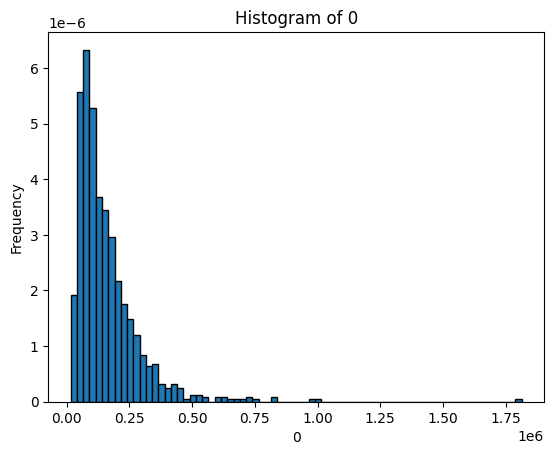

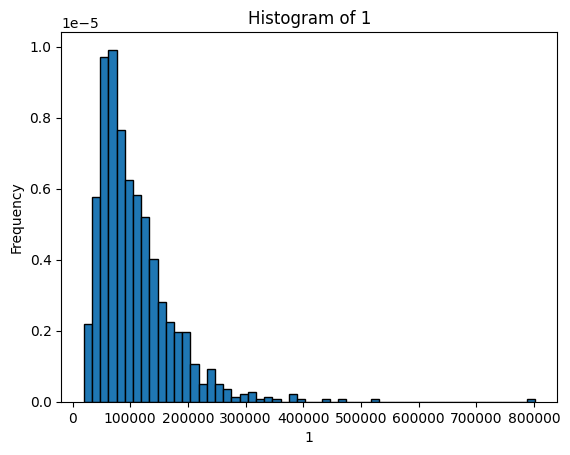

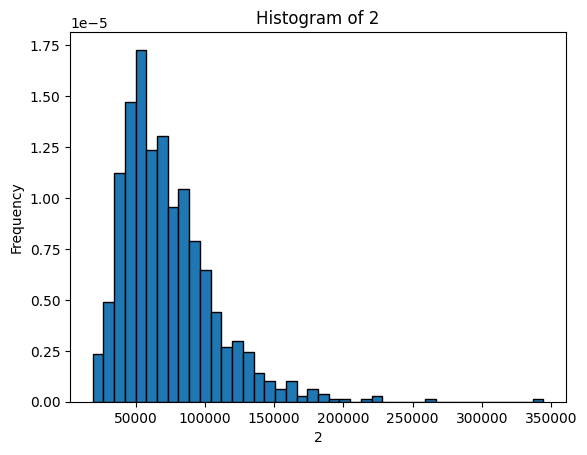

In [5]:
# Simulation control parameters 
## common seed indicator, sample size
controls = [True,1000]

# Load historical asset returns & inflation into a data frame
Asset_df = pd.read_csv('asset_data.csv') 

# Model inputs (parameters & decision variables)
## N, Y, damp, x, Asset_df (note x is a list of allocation lists)
inputs = [40,1000,0.98,[[0.1,0.1,0.8],[0.2,0.2,0.6],[0.3,0.3,0.4]],Asset_df]

# Run Monte Carlo simulation and display results
Z_df = simShell(controls,inputs)      # Generate random sample of outputs
print(simStats(Z_df))                 # Report summary stats of outputs
simHistogram(Z_df)                    # Report histgrams of outputs

In [6]:
Z_df

,0,1,2
0,48835.044668,42654.615199,36484.027840
1,100163.335844,74452.423646,54468.156049
2,42849.064986,40625.480809,37327.041682
3,92632.650715,64462.245318,44390.351093
4,106608.276293,85254.453240,66496.300881
...,...,...,...
995,205846.531904,123245.898146,71775.916327
996,117269.385146,80164.000810,53802.010027
997,94004.959838,80968.567934,67995.454183
998,52847.694417,42732.920844,33815.191700


# Results
---
* After simulating investment returns over 40yr, we can determine that an asset allocation distributed heavier among stocks, (80% stocks, 10% Bonds, 10% T-Bills) would generate the greatest returns compared to the other asset distributions.

# 100% Stock Allocation

     Sample mean   Sample stdev  Quantile 0.05  Quantile 0.95   Std error  \
0  234018.119875  256458.594139   43393.277236  643619.794614  8109.93283   

           CI-lo          CI-hi           Min           Max  
0  218122.943611  249913.296139  12615.517395  3.984553e+06  


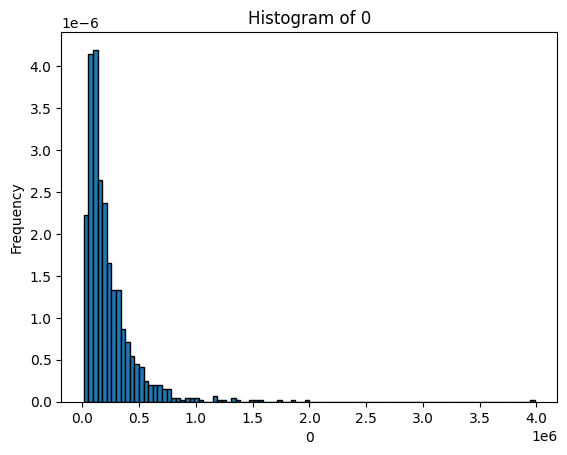

In [7]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt

def simShell(controls,inputs):
    '''
    Generic sim code: specifies deterministic model, sets some inputs as 
    random, returns random sample of model outputs stored as a data frame
    '''
    #A Unpack the controls (standardized)
    seed = controls[0]               # Determines whether common seed is used
    n = controls[1]                  # Sample size

    #B Unpack the inputs (model-dependent)
    N = inputs[0]
    Y = inputs[1]
    damp = inputs[2]
    x = inputs[3]
    hist_df = inputs[4]

    #D Use same seed (true) or not false) for random number streams
    if seed:
        np.random.seed(100)          # Can change the seed value
    
    #E Generate sample(s) of random inputs & outputs (eg, in arrays)
    ## Compute the probabilities for the discrete probability distribution
    prob = damp**np.arange(len(hist_df))  # Compute list of damping factors
    prob = (prob/sum(prob)).tolist()      # Normalize to sum to 1
    prob.reverse()                   # Reverse the order so smallest to largest prob (higher prob for recent)
    ## Store the column labels in a list for easy reference
    df_labels = hist_df.columns.tolist() 
    ## Generate samples
    sample=np.empty((0, len(x)))     # Initialize sample as empty array of dim x
    for _ in range(n):               # loop over n samples
        V = np.full(len(x),0)        # Initialize starting balance for each x
        D = 1                        # Initialize the discount factor
        for _ in range(N):           # Invest over N years
            ## Generate random index for row in hist_df
            index=np.random.choice(range(len(hist_df)),p=prob)
            ## Generate the random percent change in assets & inflation
            values = hist_df[df_labels[1:]].iloc[index]  # Random asset returns & inflation (exclude year)
            i = values.iloc[len(values)-1:].tolist()[0]  # Store inflation (last element)
            D = D/(1+i)               # Update discount factor
            ## Create list of pct change in portfolio for each allocation in x
            P = []
            for j in range(len(x)):
                P = P + [sum(values.iloc[:3]*x[j])+1]
            ## Update value of investment at end of year
            V = (V+Y) * P
        PV = V * D                    # Compute present value of portfolio
        ## add a row to the sample array
        sample=np.append(sample,[PV],axis=0)
        
    #F Store array of outputs (& desired inputs) in data frame & return
    Z_df = pd.DataFrame(sample)
    return Z_df





def simStats(Z_df):
    '''Generic code to compute summary stats for each column in a data frame (input as Z_df)'''
    # Compute sample mean, sample stdev, standard error, min, max
    Mean = Z_df.mean()
    Stdev = Z_df.std(ddof=1)              # Reduce degrees of freedom (ddof) by 1 to yield sample stdev
    Quant05 = Z_df.quantile(0.05)
    Quant95 = Z_df.quantile(0.95)
    Stderr = Z_df.sem()
    Min = Z_df.min()
    Max = Z_df.max()

    # Specify probability for confidence interval of sample mean
    CI_prob = 0.95

    # Compute confidence interval
    Tail_prob = (1 - CI_prob)/2
    z = sp.norm.ppf(1-Tail_prob)
    CI_lo = Mean - z * Stderr
    CI_hi = Mean + z * Stderr
    
    # Create & return data frame of sample statistics
    Sample_stats = pd.concat([Mean,Stdev,Quant05,Quant95,Stderr,CI_lo,CI_hi,Min,Max],axis=1)
    Sample_stats.columns = ['Sample mean', 'Sample stdev', 'Quantile 0.05','Quantile 0.95',
                            'Std error','CI-lo','CI-hi','Min','Max']
    return Sample_stats




def simHistogram(Z_df):
    '''
    Generic code to plot histograms for each column in a data frame Z_df

    '''
    # Iterate over columns
    for column in Z_df.columns:
        # Clear previous plot
        plt.clf()

        # Generate histogram for current column
        plt.hist(Z_df[column], bins='auto', edgecolor='black',density=True)

        # Set labels and title
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {column}')
        
        # Display the histogram
        plt.show()


# Simulation control parameters 
controls = [True, 1000]

# Load historical asset returns & inflation into a data frame
Asset_df = pd.read_csv('asset_data.csv') 

# Model inputs for 100% stock allocation
inputs = [40, 1000, 0.98, [[0, 0, 1]], Asset_df]

# Run Monte Carlo simulation for 100% stock allocation
Z_df = simShell(controls, inputs)
print(simStats(Z_df))
simHistogram(Z_df)


# Results
---
* After simulation of 100% stock allocation, we can determine that you have the potential to make far greater returns than a portfolio diversified among stocks, T-bills, and bonds. Allocating 100% of capital to stocks does increase risk and has the potential to make less due to not having guaranteed returns in bonds/T-bills, but based on historic market performance, that is a very unlikely possibility.